In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

import STG3Net as MODEL

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(proj_list, config):
    global graph_dict
    data_root = Path('D:\\project\\datasets\\DLPFC\\')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        ##### Load layer_guess label, if have
        truth_path = "D:\\project\\datasets\\DLPFC\\" + proj_name + '/' + proj_name + '_truth.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [2]:
with open('../Config/Config_DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['151673', '151674', '151675', '151676']
num_cluster = 7

adata, graph_dict = get_data(proj_list, config['data'])

100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [4]:
net.train(verbose=1)

Epoch 495 total loss=0.644 recon loss=0.735 tri loss=0.000 disc loss=1.292:  50%|████▉     | 496/1000 [00:11<00:10, 45.97it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 44276 nodes or edges
Processing datasets 151674 have 33400 nodes or edges
Processing datasets 151675 have 38482 nodes or edges
Processing datasets 151676 have 39112 nodes or edges


Epoch 545 total loss=1.038 recon loss=0.941 tri loss=0.242 disc loss=1.372:  55%|█████▍    | 546/1000 [00:27<00:22, 20.17it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 67253 nodes or edges
Processing datasets 151674 have 64392 nodes or edges
Processing datasets 151675 have 63152 nodes or edges


Epoch 545 total loss=1.038 recon loss=0.941 tri loss=0.242 disc loss=1.372:  55%|█████▍    | 546/1000 [00:40<00:22, 20.17it/s]

Processing datasets 151676 have 59510 nodes or edges


Epoch 595 total loss=0.931 recon loss=0.824 tri loss=0.217 disc loss=1.369:  60%|█████▉    | 596/1000 [00:43<00:19, 20.43it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 69864 nodes or edges
Processing datasets 151674 have 65694 nodes or edges
Processing datasets 151675 have 63759 nodes or edges
Processing datasets 151676 have 61006 nodes or edges


Epoch 645 total loss=0.940 recon loss=0.820 tri loss=0.232 disc loss=1.342:  65%|██████▍   | 646/1000 [00:55<00:15, 23.32it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 67893 nodes or edges
Processing datasets 151674 have 65493 nodes or edges
Processing datasets 151675 have 64259 nodes or edges
Processing datasets 151676 have 60238 nodes or edges


Epoch 695 total loss=0.919 recon loss=0.798 tri loss=0.225 disc loss=1.354:  70%|██████▉   | 697/1000 [01:08<00:13, 23.09it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 71592 nodes or edges
Processing datasets 151674 have 69822 nodes or edges
Processing datasets 151675 have 68814 nodes or edges
Processing datasets 151676 have 66080 nodes or edges


Epoch 745 total loss=0.911 recon loss=0.783 tri loss=0.223 disc loss=1.391:  75%|███████▍  | 747/1000 [01:20<00:12, 19.77it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 72693 nodes or edges
Processing datasets 151674 have 67006 nodes or edges


Epoch 745 total loss=0.911 recon loss=0.783 tri loss=0.223 disc loss=1.391:  75%|███████▍  | 747/1000 [01:30<00:12, 19.77it/s]

Processing datasets 151675 have 68144 nodes or edges
Processing datasets 151676 have 64169 nodes or edges


Epoch 795 total loss=0.884 recon loss=0.776 tri loss=0.203 disc loss=1.379:  80%|███████▉  | 796/1000 [01:34<00:09, 21.18it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 72958 nodes or edges
Processing datasets 151674 have 71585 nodes or edges
Processing datasets 151675 have 67622 nodes or edges
Processing datasets 151676 have 64802 nodes or edges


Epoch 845 total loss=0.876 recon loss=0.769 tri loss=0.198 disc loss=1.393:  85%|████████▍ | 847/1000 [01:47<00:06, 23.20it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 75435 nodes or edges
Processing datasets 151674 have 72844 nodes or edges
Processing datasets 151675 have 68603 nodes or edges
Processing datasets 151676 have 67539 nodes or edges


Epoch 895 total loss=0.864 recon loss=0.764 tri loss=0.190 disc loss=1.387:  90%|████████▉ | 897/1000 [01:59<00:05, 20.31it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 74047 nodes or edges
Processing datasets 151674 have 73684 nodes or edges
Processing datasets 151675 have 68622 nodes or edges
Processing datasets 151676 have 67773 nodes or edges


Epoch 945 total loss=0.861 recon loss=0.763 tri loss=0.190 disc loss=1.370:  95%|█████████▍| 946/1000 [02:12<00:02, 22.48it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 76483 nodes or edges
Processing datasets 151674 have 74601 nodes or edges
Processing datasets 151675 have 71762 nodes or edges
Processing datasets 151676 have 69532 nodes or edges


Epoch 980 total loss=0.862 recon loss=0.758 tri loss=0.193 disc loss=1.375:  98%|█████████▊| 980/1000 [02:24<00:02,  6.76it/s]

Stop trainning because of loss convergence


In [5]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
print(adata)

AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'G3STNet_Domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'latent', 'recon'
    layers: 'count'


In [6]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [7]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")


total ARI:0.5945401910581043
151673 ARI:0.6079630599379231
151674 ARI:0.5995601438407226
151675 ARI:0.5885804609535115
151676 ARI:0.5972539465634947


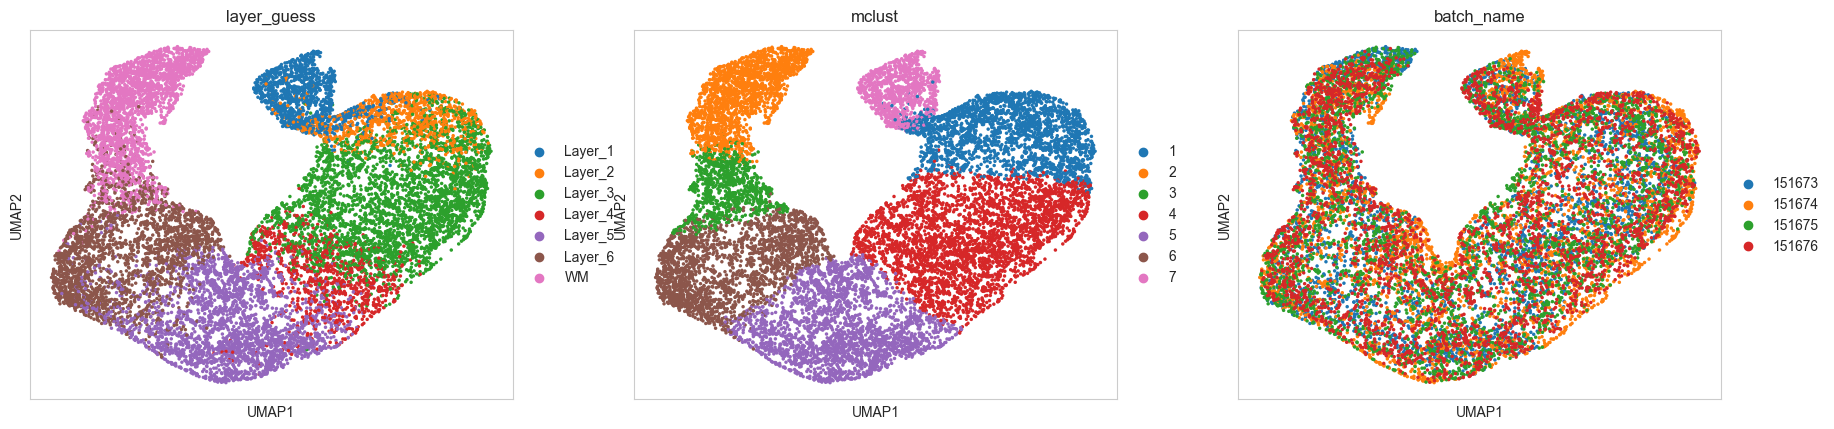

In [8]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = MODEL.compute_ARI(sub_adata, f'layer_guess', f'mclust')
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = MODEL.compute_ARI(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{ARI}")

total ARI:0.5945401910581043
0.6079630599379231
0.5995601438407226
0.5885804609535115
0.5972539465634947


In [10]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = MODEL.compute_NMI(sub_adata, f'layer_guess', f'mclust')
print(f"total NMI:{NMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = MODEL.compute_NMI(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{NMI}")

total NMI:0.711241585616285
0.7259023262333699
0.7255127473836759
0.713328804946679
0.712658726001235


In [11]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = MODEL.compute_HOM(sub_adata, f'layer_guess', f'mclust')
print(f"total HOM:{HOM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = MODEL.compute_HOM(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{HOM}")

total HOM:0.7147311648145184
0.7337888724947388
0.7323895380745354
0.7121691756468866
0.7154387759940808


In [12]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
COM = MODEL.compute_COM(sub_adata, f'layer_guess', f'mclust')
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    COM = MODEL.compute_COM(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{COM}")

total COM:0.7077859156669343
0.7181835018901334
0.7187638950240125
0.7144922168682939
0.7099001978000302


In [13]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
CHAOS = MODEL.compute_CHAOS(sub_adata, f'mclust')
print(f"total CHAOS:{CHAOS}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    CHAOS = MODEL.compute_CHAOS(sub_adata_tmp, f'mclust')
    print(f"{CHAOS}")

total CHAOS:0.018641454923479267
0.060756409036279775
0.0598562274087717
0.06114803241673941
0.06267174408418287


In [14]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
PAS = MODEL.compute_PAS(sub_adata, f'mclust')
print(f"total PAS:{PAS}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    PAS = MODEL.compute_PAS(sub_adata_tmp, f'mclust')
    print(f"{PAS}")

total PAS:0.22797163518921576
0.03572417612849626
0.03218707015130674
0.05243970835670219
0.04838239580297289


In [15]:
import harmonypy as hm

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    num_domains = len(set(Tmp_adata.obs[PD_key])) - 1
    num_batchs = len(set(Tmp_adata.obs[BT_key])) - 1
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]
    norm_batch = (LISI_batch_norm - 1)/num_batchs
    norm_domain = (LISI_domain_norm - 1)/num_domains
    LISI = 2*(1-norm_domain)*norm_batch / (1-norm_domain+norm_batch)
    return LISI , norm_batch, norm_domain

In [16]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
LISI , norm_batch, norm_domain = compute_fscoreLISI(sub_adata, 'latent', 'batch_name', 'layer_guess')

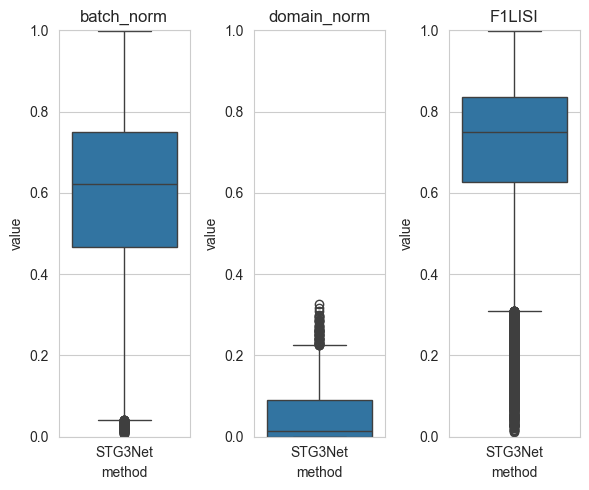

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

df_batch_norm = pd.DataFrame({
    'method': 'STG3Net',
    'value': norm_batch,
    'type': ['batch_norm'] * len(norm_batch)
})

df_domain_norm = pd.DataFrame({
    'method': 'STG3Net',
    'value': norm_domain,
    'type': ['domain_norm'] * len(norm_domain)
})

df_F1LISI = pd.DataFrame({
    'method': 'STG3Net',
    'value': LISI,
    'type': ['F1LISI'] * len(LISI)
})

fig, axes = plt.subplots(1, 3, figsize=(6, 5))
sns.boxplot(data=df_batch_norm, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_domain_norm, x='method', y='value', ax=axes[1])
sns.boxplot(data=df_F1LISI, x='method', y='value', ax=axes[2])
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)
axes[0].set_title('batch_norm')
axes[1].set_title('domain_norm')
axes[2].set_title('F1LISI')
plt.tight_layout()

In [18]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))


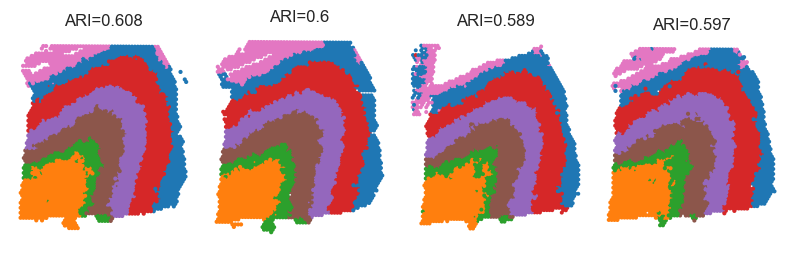

In [19]:

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()